In [221]:
using NBInclude
@nbinclude("julia_function.ipynb")

allskyts2 (generic function with 1 method)

In [2]:
# Defining oscillation probability function with distinct mass splitting values

function oscprobdistinct(et, dm21, dm22, dm23, leff)

    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    osc1 = (cos((dm21 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm22 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm23 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(u[1]*u[1]) + osc2*(u[4]*u[4]) + osc3*(u[7]*u[7])
    prob_mue = osc1*(u[1]*u[2]) + osc2*(u[4]*u[5]) + osc3*(u[7]*u[8])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

# Redefining event distribution functions

function smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprobdistinct.(et, dm21, dm22, dm23, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistdistinct(dm21, dm22, dm23, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinneddistinct (generic function with 1 method)

In [480]:
function anglesmearbin1(dm2, ϕ₀, γ, res, nb)

    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    # This is more of a shortcut but honestly could be implemented long term,
    # setting all the event numbers outside of -pi/4 to pi/4 to 0 because they're so small anyway it doesn't really
    # change anything
    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, (-b), 0.5, bsize, ϕ₀, γ)
            end
        end
    end

    edistvals1 = transpose(skybins)

    # Now the data are split into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 150
    npix = hp.nside2npix(nside)
    thedges = (bsize):bsize:(π-bsize)
    phedges = (0+bsize/2):bsize:(2π-bsize/2)
    theta, phi = np.meshgrid(thedges, phedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    function dist(index)

        # bin = reshape(ebins[index], 45, 90)
        bin = ebins[index]
        e = []
        
        for (j, thval) in enumerate(thedges)
            for (i, phval) in enumerate(phedges)
                    push!(e, bin[i, j])
            end
        end
    
        E = np.zeros(hp.nside2npix(nside))
    
        # E[pixel_indices] = e
        
        for (i, eval) in enumerate(e)
            E[pixel_indices[i]] = eval
        end
        
        E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))
    
        twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
    end

    # res in number of bins: each bin is 0.00785 radians, 400/res must be an integer
    nbins = convert(Int, 400/res)
    
    function anglebin(index, res)

        ebin = dist(index)
    
        bsize_l = res
        bsize_b = res
    
        nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
        nbins_b = convert(Int, (size(ebin, 2)/bsize_b))
    
        binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)
    
        bins = sum(binned_mat, dims=(1, 3))
    
        binned_sums = reshape(bins, nbins_l, nbins_b)
    end

    allsky_ebins = [anglebin(ebin, res) for ebin in 1:50]

    allskyedists = [zeros(50) for _ in 1:nbins, _ in 1:(2*nbins)]

    for i in 1:nbins
        for j in 1:(2*nbins)
            allskyedists[i, j] = [allsky_ebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

# Doesn't smear by angle because taking the all sky events
function allskyevents_distinct(dm21, dm22, dm23, ϕ₀, γ, σ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinneddistinct(dm21, dm22, dm23, l, (-b), σ, bsize, ϕ₀, γ)
            end
        end
    end

    return sum(skybins)
end

allskyevents_distinct (generic function with 1 method)

In [11]:
allskyevents_perfectangres = sum(allskyevents(0, 21.8, 2.7, 80))
allskyevents_7edist = sum(sum(anglesmearbin1(0, 21.8, 2.7, 16, 80)))

println("events (perfect res): $allskyevents_perfectangres \nevents (7 deg res): $allskyevents_7edist")

events (perfect res): 674.8812706399883 
events (7 deg res): 509.4470056805786


In [479]:
# Fixed our problem with the new angular smearing implementation

allskyevents_perfectangres = sum(allskyevents(0, 21.8, 2.7, 80))
allskyevents_7edist = sum(sum(anglesmear(0, 21.8, 2.7, 0.5, 7, 80)))

println("events (perfect res): $allskyevents_perfectangres \nevents (7 deg res): $allskyevents_7edist")

events (perfect res): 674.8812706399883 
events (7 deg res): 674.845564589707


In [481]:
# Printing out distributions

maps = anglesmear(0, 21.8, 2.7, 0.5, 7, 80)

bsize = π/80

0.039269908169872414

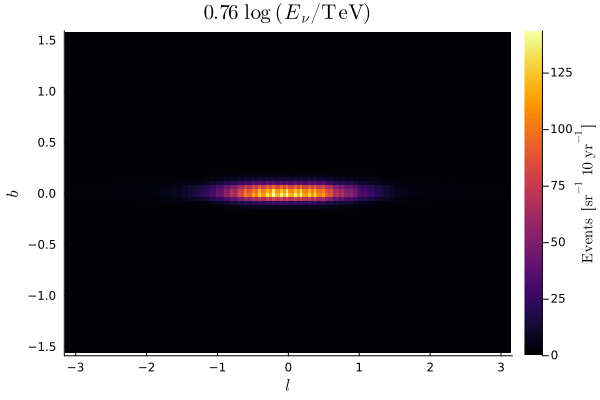

In [491]:
# Plotting the distributions

heatmap(
    (-π):bsize:(π),
    (-π/2):bsize:(π/2),
    convΩ(maps[15], π/80),
    title=L"0.76~\log~(E_{\nu} / \mathrm{TeV})",
    xlabel=L"l",
    ylabel=L"b",
    colorbar_title=L"\mathrm{Events}~~[\mathrm{sr}^{-1}~10~\mathrm{yr}^{-1}]"
)

In [142]:
function allskyteststats(dm2, σ)

    mxlhallsky = allskymaxlh2(dm2, σ)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = allskyevents(0, 21.8, 2.7, 80)
    askyeventsalt_maxlh = allskyevents(dm2, allskymaxparams[1], allskymaxparams[2], 80)

    ts = lrt(askyevents_null, askyeventsalt_maxlh)
end

function negloglh_distinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)

    # σ = 0.5
    nullhyp = edistbinneddistinct(0, 0, 0, l, b, σ, θ, 21.8, 2.7)
    althyp = edistbinneddistinct(dm21, dm22, dm23, l, b, σ, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

# Approximate negloglh all sky function
function allskynllh_distinct(dm21, dm22, dm23, ϕ₀, γ, σ)

    sumllh = 0

    for lval in (-pi/2):0.122:(pi/2)
        for bval in (-0.122):0.122:(0.122)
            sumllh += negloglh_distinct(dm21, dm22, dm23, lval, bval, σ, 0.122, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh_distinct(dm21, dm22, dm23, σ)

    function nllh(test)
        return allskynllh_distinct(dm21, dm22, dm23, test[1], test[2], σ)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end


function allskyteststats_distinct(dm21, dm22, dm23, σ)

    mxlhallsky = allskymaxlh_distinct(dm21, dm22, dm23, σ)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = allskyevents_distinct(0, 0, 0, 21.8, 2.7, σ, 80)
    askyeventsalt_maxlh = allskyevents_distinct(dm21, dm22, dm23, allskymaxparams[1], allskymaxparams[2], σ, 80)

    ts = lrt(askyevents_null, askyeventsalt_maxlh)
end

allskyteststats_distinct (generic function with 1 method)

In [143]:
allskyteststats_distinct(10^(-14), 10^(-14), 10^(-14), 0.5)

20.67128007302224

In [161]:
logdm21s = range(-15, -13, 10)
logdm22s = range(-15, -13, 10)

dm21s = 10 .^ logdm21s
dm22s = 10 .^ logdm22s
dm23 = 10^(-14)

teststatsdistinct = [allskyteststats_distinct(dm21, dm22, dm23, 0.01) for dm22 in dm22s, dm21 in dm21s]

10×10 Matrix{Float64}:
 1.4035    5.56315  14.2452  11.4575  …   5.99001   4.68082   3.39476
 3.15194   9.67102  22.7664  16.4893      5.39003   4.66873   3.95331
 5.62791  15.2225   36.2429  28.481       5.45705   5.58518   5.7379
 3.85164  10.5755   29.0546  36.4993      5.08258   4.87641   5.12528
 2.28461   6.06048  17.498   25.1086      8.76293   6.61464   5.91792
 1.63627   4.16776  12.8443  14.926   …  14.7784    9.75401   7.29489
 1.33033   3.72727  11.8452  11.8172     22.2641   13.213     8.57443
 1.20006   3.94583  12.5658  11.7781     27.6104   17.7968   10.234
 1.1385    4.35813  13.7836  12.9067     19.9146   21.0754   12.9238
 1.08069   4.74373  14.921   14.2146     15.0087   14.9268   14.7801

In [162]:
# writedlm("misc_data/allsky_distinct_dm2_vals_001_res.txt", teststatsdistinct)

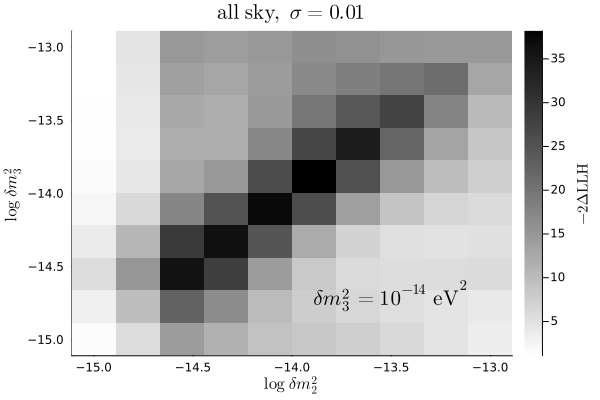

In [164]:
heatmap(
    logdm21s,
    logdm22s,
    teststatsdistinct,
    c=:grayC,
    xlabel=L"\log~\delta m_2^2",
    ylabel=L"\log~\delta m_3^2",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"\mathrm{all~sky},~\sigma = 0.01",
    ann=[(-13.5, -14.7, L"\delta m_3^2 = 10^{-14}~\mathrm{eV}^2")],
)

In [165]:
# savefig("misc_plots/allsky_distinct_dm2_vals_001_res.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/allsky_distinct_dm2_vals_001_res.png"